# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [1]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 895 kB 15.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.6 MB/s 
     |████████████████████████████████| 1.8 MB 24.2 MB/s 
     |████████████████████████████████| 170 kB 62.8 MB/s 
     |████████████████████████████████| 97 kB 9.0 MB/s 
     |████████████████████████████████| 138 kB 67.2 MB/s 
     |████████████████████████████████| 133 kB 52.8 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=f2150e5d15b7d04ae02a95f1374a4786b9a23492c88c5a7beebddc37c8617203
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=95c77975a13a52ddeb360982c48085d9bb4b5139bdc45c717eb4af1bac2bc2cd
  Sto

In [2]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 28917, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 28917 (delta 180), reused 296 (delta 132), pack-reused 28534
Receiving objects: 100% (28917/28917), 12.24 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (21635/21635), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary dir

In [3]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [4]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [5]:
#!apt-get install megatools

## 下載檔案並解壓縮

下载数据并解压

In [5]:
!gdown --id '15f5ZghJJ1AQ9rARr4XDNCQcfxGXtzWyt' --output ted2020.tgz
!gdown --id '18WjD1jP5p7g6E3YuAJs6PaAADvhKEbuq' --output test.tgz
!tar -xvf ted2020.tgz 
!tar -xvf test.tgz 

Downloading...
From: https://drive.google.com/uc?id=15f5ZghJJ1AQ9rARr4XDNCQcfxGXtzWyt
To: /content/ted2020.tgz
28.6MB [00:00, 108MB/s] 
Downloading...
From: https://drive.google.com/uc?id=18WjD1jP5p7g6E3YuAJs6PaAADvhKEbuq
To: /content/test.tgz
100% 150k/150k [00:00<00:00, 55.6MB/s]
raw.en
raw.zh
test.en
test.zh


将数据移到给定目录下

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
prefix = Path(data_dir).absolute() / dataset_name
prefix.mkdir(parents=True, exist_ok=True)
print(prefix)
!mv {'raw.en'} {prefix/'train_dev.raw.en'}
!mv {'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {'test.en'} {prefix/'test.raw.en'}
!mv {'test.zh'} {prefix/'test.raw.zh'}

/content/DATA/rawdata/ted2020


In [12]:
'''
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
#      "https://drive.google.com/file/d/15f5ZghJJ1AQ9rARr4XDNCQcfxGXtzWyt/view?usp=sharing",
#      "https://drive.google.com/file/d/18WjD1jP5p7g6E3YuAJs6PaAADvhKEbuq/view?usp=sharing"
)
file_names = (
    'ted2020', # train & dev
    'test', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
print(prefix)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         if 'mega' in u:
#             !megadl {u} --path {path}
#         else:
#             !wget {u} -O {path}
#     print("********************")
#     print(path.suffix,path,prefix)
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}
'''

/content/DATA/rawdata/ted2020


## 設定語言

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [9]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [12]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## 用 fairseq 將資料轉為 binary

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-08-03 02:26:16 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# 實驗的參數設定表

In [19]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [20]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [21]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-08-03 02:30:53 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-08-03 02:30:53 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 14.756 GB ; name = Tesla T4                                
2021-08-03 02:30:53 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [22]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-08-03 02:31:04 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-08-03 02:31:04 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [23]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-08-03 02:31:15 | INFO | hw5.seq2seq | loading data for epoch 1
2021-08-03 02:31:15 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-08-03 02:31:16 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-08-03 02:31:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2021-08-03 02:31:16 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-08-03 02:31:16 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-08-03 02:31:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [24]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [25]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-08-03 02:31:37 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'net_input': {'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([19]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]])},
 'nsentences': 1,
 'ntokens': 18,
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [26]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [101]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # 過雙向RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions] 是最上層RNN的輸出
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # 這個beam search時會用到，意義並不是很重要
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [27]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding位置的attention
        if encoder_padding_mask is not None:
            # 利用broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # 在source對應維度softmax
        attn_scores = F.softmax(attn_scores, dim=-1)

        # 形狀 (B, T, S) x (B, S, dim) = (B, T, dim) 加權平均
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # 回復形狀 (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [103]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # 取出encoder的輸出
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # 有上個timestep留下的資訊，讀進來就可以繼續decode，不用從bos重來
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # 沒有incremental state代表這是training或者是test time時的第一步
            # 準備seq2seq: 把encoder_hiddens pass進去decoder的hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # 做decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # 過單向RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # 投影到embedding size (如果hidden 和embed size不一樣，然後share_embedding又設成True,需要額外project一次)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # 投影到vocab size 的分佈
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # 如果是Incremental, 記錄這個timestep的hidden states, 下個timestep讀回來
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # 這個beam search時會用到，意義並不是很重要
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [28]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [29]:
# HINT: transformer 架構
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [30]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [31]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [32]:
model = build_model(arch_args, task)
logger.info(model)

2021-08-03 02:33:02 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [33]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [34]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

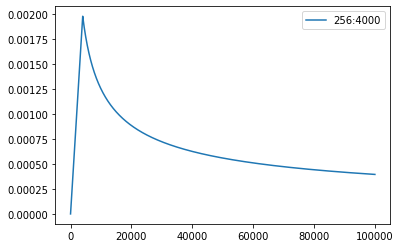

In [35]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [36]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [37]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [38]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [39]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [40]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [41]:
!nvidia-smi

Tue Aug  3 02:34:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |   1116MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-08-03 02:34:47 | INFO | hw5.seq2seq | task: TranslationTask
2021-08-03 02:34:47 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-08-03 02:34:47 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-08-03 02:34:47 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-08-03 02:34:47 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-08-03 02:34:47 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2021-08-03 02:34:47 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [43]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-08-03 02:35:12 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-08-03 02:35:13 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


2021-08-03 02:38:30 | INFO | hw5.seq2seq | training loss: 7.0574
2021-08-03 02:38:30 | INFO | hw5.seq2seq | begin validation


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


2021-08-03 02:38:58 | INFO | hw5.seq2seq | example source: but the point is , it doesn't feel that way .
2021-08-03 02:38:58 | INFO | hw5.seq2seq | example hypothesis: 所以 , 這裡 , 這樣 , 這樣 。
2021-08-03 02:38:58 | INFO | hw5.seq2seq | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2021-08-03 02:38:58 | INFO | hw5.seq2seq | validation loss:	5.9902
2021-08-03 02:38:58 | INFO | hw5.seq2seq | BLEU = 0.71 14.6/2.3/0.4/0.1 (BP = 0.771 ratio = 0.793 hyp_len = 88692 ref_len = 111811)
2021-08-03 02:38:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint1.pt
2021-08-03 02:38:58 | INFO | hw5.seq2seq | end of epoch 1


2021-08-03 02:42:17 | INFO | hw5.seq2seq | training loss: 5.5271
2021-08-03 02:42:17 | INFO | hw5.seq2seq | begin validation


2021-08-03 02:42:38 | INFO | hw5.seq2seq | example source: we can push through that .
2021-08-03 02:42:38 | INFO | hw5.seq2seq | example hypothesis: 我們可以把這個轉換 。
2021-08-03 02:42:38 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2021-08-03 02:42:38 | INFO | hw5.seq2seq | validation loss:	5.0249
2021-08-03 02:42:38 | INFO | hw5.seq2seq | BLEU = 7.38 41.4/15.8/6.5/2.7 (BP = 0.710 ratio = 0.745 hyp_len = 83287 ref_len = 111811)
2021-08-03 02:42:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint2.pt
2021-08-03 02:42:38 | INFO | hw5.seq2seq | end of epoch 2


2021-08-03 02:45:55 | INFO | hw5.seq2seq | training loss: 4.9204
2021-08-03 02:45:55 | INFO | hw5.seq2seq | begin validation


2021-08-03 02:46:20 | INFO | hw5.seq2seq | example source: thank you .
2021-08-03 02:46:20 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-08-03 02:46:20 | INFO | hw5.seq2seq | example reference: 謝謝 。
2021-08-03 02:46:20 | INFO | hw5.seq2seq | validation loss:	4.5446
2021-08-03 02:46:20 | INFO | hw5.seq2seq | BLEU = 11.90 43.4/19.0/9.1/4.6 (BP = 0.873 ratio = 0.880 hyp_len = 98448 ref_len = 111811)
2021-08-03 02:46:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint3.pt
2021-08-03 02:46:21 | INFO | hw5.seq2seq | end of epoch 3


2021-08-03 02:49:39 | INFO | hw5.seq2seq | training loss: 4.6210
2021-08-03 02:49:39 | INFO | hw5.seq2seq | begin validation


2021-08-03 02:50:06 | INFO | hw5.seq2seq | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2021-08-03 02:50:06 | INFO | hw5.seq2seq | example hypothesis: 那些男人最終會被邀請一千五千磅的探險 , 其中五百磅的探險會被邀請在世界各地 , 到北極地區 , 到北極地區 , 到北部 , 到北部 , 被殺死了 。
2021-08-03 02:50:06 | INFO | hw5.seq2seq | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2021-08-03 02:50:06 | INFO | hw5.seq2seq | validation loss:	4.3193
2021-08-03 02:50:06 | INFO | hw5.seq2seq | BLEU = 13.69 45.7/21.2/10.7/5.7 (BP = 0.880 ratio = 0.887 hyp_len = 99125 ref_len = 111811)
2021-08-03 02:50:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint4.pt
2021-08-03 02:50:06 | INFO | hw5.seq2seq | end of epoch 4


2021-08-03 02:53:24 | INFO | hw5.seq2seq | training loss: 4.4264
2021-08-03 02:53:24 | INFO | hw5.seq2seq | begin validation


2021-08-03 02:53:50 | INFO | hw5.seq2seq | example source: but this is really how i go about creating these photographs .
2021-08-03 02:53:50 | INFO | hw5.seq2seq | example hypothesis: 但這真的是我如何創造這些照片 。
2021-08-03 02:53:50 | INFO | hw5.seq2seq | example reference: 但是我真的是這樣做出這些相片的 。
2021-08-03 02:53:50 | INFO | hw5.seq2seq | validation loss:	4.1364
2021-08-03 02:53:50 | INFO | hw5.seq2seq | BLEU = 16.50 48.1/23.3/12.3/6.7 (BP = 0.946 ratio = 0.947 hyp_len = 105881 ref_len = 111811)
2021-08-03 02:53:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint5.pt
2021-08-03 02:53:50 | INFO | hw5.seq2seq | end of epoch 5


2021-08-03 02:57:08 | INFO | hw5.seq2seq | training loss: 4.2677
2021-08-03 02:57:08 | INFO | hw5.seq2seq | begin validation


2021-08-03 02:57:35 | INFO | hw5.seq2seq | example source: so that is a fact .
2021-08-03 02:57:35 | INFO | hw5.seq2seq | example hypothesis: 這是事實 。
2021-08-03 02:57:35 | INFO | hw5.seq2seq | example reference: 這就是事實
2021-08-03 02:57:35 | INFO | hw5.seq2seq | validation loss:	4.0042
2021-08-03 02:57:35 | INFO | hw5.seq2seq | BLEU = 17.97 51.5/25.9/13.9/7.9 (BP = 0.919 ratio = 0.922 hyp_len = 103104 ref_len = 111811)
2021-08-03 02:57:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint6.pt
2021-08-03 02:57:35 | INFO | hw5.seq2seq | end of epoch 6


2021-08-03 03:00:53 | INFO | hw5.seq2seq | training loss: 4.1291
2021-08-03 03:00:53 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:01:19 | INFO | hw5.seq2seq | example source: thank you so much everyone .
2021-08-03 03:01:19 | INFO | hw5.seq2seq | example hypothesis: 非常謝謝謝
2021-08-03 03:01:19 | INFO | hw5.seq2seq | example reference: 謝謝大家 !
2021-08-03 03:01:19 | INFO | hw5.seq2seq | validation loss:	3.9248
2021-08-03 03:01:19 | INFO | hw5.seq2seq | BLEU = 18.05 53.7/27.5/14.9/8.6 (BP = 0.865 ratio = 0.873 hyp_len = 97663 ref_len = 111811)
2021-08-03 03:01:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint7.pt
2021-08-03 03:01:19 | INFO | hw5.seq2seq | end of epoch 7


2021-08-03 03:04:37 | INFO | hw5.seq2seq | training loss: 4.0309
2021-08-03 03:04:37 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:05:02 | INFO | hw5.seq2seq | example source: these differences became a source of inspired artistic celebration .
2021-08-03 03:05:02 | INFO | hw5.seq2seq | example hypothesis: 這些差異變成了啟發藝術慶祝的源頭 。
2021-08-03 03:05:02 | INFO | hw5.seq2seq | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2021-08-03 03:05:02 | INFO | hw5.seq2seq | validation loss:	3.8206
2021-08-03 03:05:02 | INFO | hw5.seq2seq | BLEU = 19.36 54.8/28.7/15.9/9.3 (BP = 0.881 ratio = 0.887 hyp_len = 99228 ref_len = 111811)
2021-08-03 03:05:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint8.pt
2021-08-03 03:05:03 | INFO | hw5.seq2seq | end of epoch 8


2021-08-03 03:08:20 | INFO | hw5.seq2seq | training loss: 3.9548
2021-08-03 03:08:20 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:08:47 | INFO | hw5.seq2seq | example source: it's not .
2021-08-03 03:08:47 | INFO | hw5.seq2seq | example hypothesis: 不是 。
2021-08-03 03:08:47 | INFO | hw5.seq2seq | example reference: 不是
2021-08-03 03:08:47 | INFO | hw5.seq2seq | validation loss:	3.7896
2021-08-03 03:08:47 | INFO | hw5.seq2seq | BLEU = 20.64 51.5/27.0/14.9/8.7 (BP = 1.000 ratio = 1.007 hyp_len = 112540 ref_len = 111811)
2021-08-03 03:08:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint9.pt
2021-08-03 03:08:47 | INFO | hw5.seq2seq | end of epoch 9


2021-08-03 03:12:05 | INFO | hw5.seq2seq | training loss: 3.8992
2021-08-03 03:12:05 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:12:28 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2021-08-03 03:12:28 | INFO | hw5.seq2seq | example hypothesis: 想想看 , 當你有朋友、家庭和同事在加州 , 在西岸或其他地方 。
2021-08-03 03:12:28 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2021-08-03 03:12:28 | INFO | hw5.seq2seq | validation loss:	3.7314
2021-08-03 03:12:28 | INFO | hw5.seq2seq | BLEU = 20.47 56.4/29.9/16.7/9.9 (BP = 0.892 ratio = 0.897 hyp_len = 100317 ref_len = 111811)
2021-08-03 03:12:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint10.pt
2021-08-03 03:12:28 | INFO | hw5.seq2seq | end of epoch 10


2021-08-03 03:15:47 | INFO | hw5.seq2seq | training loss: 3.8529
2021-08-03 03:15:47 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:16:11 | INFO | hw5.seq2seq | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2021-08-03 03:16:11 | INFO | hw5.seq2seq | example hypothesis: 我被要求搬出去 , 因為我的房間之一和她的父母分享我的地位 。
2021-08-03 03:16:11 | INFO | hw5.seq2seq | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2021-08-03 03:16:11 | INFO | hw5.seq2seq | validation loss:	3.7094
2021-08-03 03:16:11 | INFO | hw5.seq2seq | BLEU = 21.25 55.6/29.7/16.7/9.8 (BP = 0.932 ratio = 0.934 hyp_len = 104452 ref_len = 111811)
2021-08-03 03:16:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint11.pt
2021-08-03 03:16:11 | INFO | hw5.seq2seq | end of epoch 11


2021-08-03 03:19:28 | INFO | hw5.seq2seq | training loss: 3.8179
2021-08-03 03:19:28 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:19:52 | INFO | hw5.seq2seq | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2021-08-03 03:19:52 | INFO | hw5.seq2seq | example hypothesis: 我想跟各位分享一個快速的影片 , 讓我們的設備能讓你了解這有多大 。
2021-08-03 03:19:52 | INFO | hw5.seq2seq | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2021-08-03 03:19:52 | INFO | hw5.seq2seq | validation loss:	3.6643
2021-08-03 03:19:52 | INFO | hw5.seq2seq | BLEU = 21.31 56.1/30.1/16.9/10.1 (BP = 0.921 ratio = 0.924 hyp_len = 103263 ref_len = 111811)
2021-08-03 03:19:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint12.pt
2021-08-03 03:19:52 | INFO | hw5.seq2seq | end of epoch 12


2021-08-03 03:23:09 | INFO | hw5.seq2seq | training loss: 3.7861
2021-08-03 03:23:09 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:23:34 | INFO | hw5.seq2seq | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2021-08-03 03:23:34 | INFO | hw5.seq2seq | example hypothesis: 或許我們可能在兩個諾貝爾雷射和約翰納許曼和約翰納許之間做分別 。
2021-08-03 03:23:34 | INFO | hw5.seq2seq | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2021-08-03 03:23:34 | INFO | hw5.seq2seq | validation loss:	3.6527
2021-08-03 03:23:34 | INFO | hw5.seq2seq | BLEU = 21.49 56.9/30.8/17.5/10.5 (BP = 0.902 ratio = 0.907 hyp_len = 101364 ref_len = 111811)
2021-08-03 03:23:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint13.pt
2021-08-03 03:23:34 | INFO | hw5.seq2seq | end of epoch 13


2021-08-03 03:26:52 | INFO | hw5.seq2seq | training loss: 3.7590
2021-08-03 03:26:52 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:27:15 | INFO | hw5.seq2seq | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2021-08-03 03:27:15 | INFO | hw5.seq2seq | example hypothesis: 在那裡 , 年輕女孩的智慧字眼 , 會永遠影響我的人生 。
2021-08-03 03:27:15 | INFO | hw5.seq2seq | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2021-08-03 03:27:15 | INFO | hw5.seq2seq | validation loss:	3.6377
2021-08-03 03:27:15 | INFO | hw5.seq2seq | BLEU = 21.08 58.3/31.5/17.9/10.8 (BP = 0.864 ratio = 0.872 hyp_len = 97533 ref_len = 111811)
2021-08-03 03:27:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint14.pt
2021-08-03 03:27:15 | INFO | hw5.seq2seq | end of epoch 14


2021-08-03 03:30:34 | INFO | hw5.seq2seq | training loss: 3.7397
2021-08-03 03:30:34 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:30:58 | INFO | hw5.seq2seq | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2021-08-03 03:30:58 | INFO | hw5.seq2seq | example hypothesis: 我們開始做曲線 , 不僅是它很美麗 , 人們可以看到你關心孩子的地位 。
2021-08-03 03:30:58 | INFO | hw5.seq2seq | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2021-08-03 03:30:58 | INFO | hw5.seq2seq | validation loss:	3.6186
2021-08-03 03:30:58 | INFO | hw5.seq2seq | BLEU = 21.49 57.9/31.5/17.9/10.7 (BP = 0.883 ratio = 0.889 hyp_len = 99411 ref_len = 111811)
2021-08-03 03:30:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint15.pt
2021-08-03 03:30:58 | INFO | hw5.seq2seq | end of epoch 15


2021-08-03 03:34:17 | INFO | hw5.seq2seq | training loss: 3.7140
2021-08-03 03:34:17 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:34:40 | INFO | hw5.seq2seq | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2021-08-03 03:34:40 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我並不是建議我們不想在胃裡養育嬰兒 , 但我建議 , 我們可能想要管理腸道中的氣體秘密 。
2021-08-03 03:34:40 | INFO | hw5.seq2seq | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2021-08-03 03:34:40 | INFO | hw5.seq2seq | validation loss:	3.6022
2021-08-03 03:34:40 | INFO | hw5.seq2seq | BLEU = 22.42 56.6/30.7/17.6/10.6 (BP = 0.940 ratio = 0.942 hyp_len = 105288 ref_len = 111811)
2021-08-03 03:34:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint16.pt
2021-08-03 03:34:40 | INFO | hw5.seq2seq | end of epoch 16


2021-08-03 03:38:00 | INFO | hw5.seq2seq | training loss: 3.6986
2021-08-03 03:38:00 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:38:24 | INFO | hw5.seq2seq | example source: so we're hoping that's what they'll do .
2021-08-03 03:38:24 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們希望他們會這樣做 。
2021-08-03 03:38:24 | INFO | hw5.seq2seq | example reference: 所以 , 我們希望它們能夠幫忙 。
2021-08-03 03:38:24 | INFO | hw5.seq2seq | validation loss:	3.5913
2021-08-03 03:38:24 | INFO | hw5.seq2seq | BLEU = 22.57 56.9/31.0/17.8/10.7 (BP = 0.937 ratio = 0.939 hyp_len = 104954 ref_len = 111811)
2021-08-03 03:38:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint17.pt
2021-08-03 03:38:24 | INFO | hw5.seq2seq | end of epoch 17


2021-08-03 03:41:44 | INFO | hw5.seq2seq | training loss: 3.6807
2021-08-03 03:41:44 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:42:08 | INFO | hw5.seq2seq | example source: i remember so vividly that day .
2021-08-03 03:42:08 | INFO | hw5.seq2seq | example hypothesis: 我記得那天如此惡劣 。
2021-08-03 03:42:08 | INFO | hw5.seq2seq | example reference: 我對那一天還記憶猶新 。
2021-08-03 03:42:08 | INFO | hw5.seq2seq | validation loss:	3.5788
2021-08-03 03:42:08 | INFO | hw5.seq2seq | BLEU = 22.48 57.2/31.3/17.9/10.8 (BP = 0.927 ratio = 0.930 hyp_len = 103948 ref_len = 111811)
2021-08-03 03:42:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint18.pt
2021-08-03 03:42:08 | INFO | hw5.seq2seq | end of epoch 18


2021-08-03 03:45:29 | INFO | hw5.seq2seq | training loss: 3.6668
2021-08-03 03:45:29 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:45:52 | INFO | hw5.seq2seq | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2021-08-03 03:45:52 | INFO | hw5.seq2seq | example hypothesis: 下一步是要製造複雜的腳趾 , 試著加上脊椎和爪子 , 並把它放到乾燥的黏土上 。
2021-08-03 03:45:53 | INFO | hw5.seq2seq | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2021-08-03 03:45:53 | INFO | hw5.seq2seq | validation loss:	3.5706
2021-08-03 03:45:53 | INFO | hw5.seq2seq | BLEU = 22.97 57.3/31.5/18.1/11.0 (BP = 0.938 ratio = 0.940 hyp_len = 105110 ref_len = 111811)
2021-08-03 03:45:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint19.pt
2021-08-03 03:45:53 | INFO | hw5.seq2seq | end of epoch 19


2021-08-03 03:49:15 | INFO | hw5.seq2seq | training loss: 3.6526
2021-08-03 03:49:15 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:49:38 | INFO | hw5.seq2seq | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2021-08-03 03:49:38 | INFO | hw5.seq2seq | example hypothesis: 然後從嬰兒的脖子中得到玉米 , 有個健康的尖叫 , 可蘭花嬰兒抵達 , 就像爸爸從停車場跑出來的一樣 , 「 嗨 , 你有兒子 , 我是達里亞博士 。
2021-08-03 03:49:38 | INFO | hw5.seq2seq | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2021-08-03 03:49:38 | INFO | hw5.seq2seq | validation loss:	3.5535
2021-08-03 03:49:38 | INFO | hw5.seq2seq | BLEU = 22.87 57.5/31.6/18.2/11.1 (BP = 0.929 ratio = 0.931 hyp_len = 104106 ref_len = 111811)
2021-08-03 03:49:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint20.pt
2021-08-03 03:49:38 | INFO | hw5.seq2seq | end of epoch 20


2021-08-03 03:53:01 | INFO | hw5.seq2seq | training loss: 3.6444
2021-08-03 03:53:01 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:53:24 | INFO | hw5.seq2seq | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2021-08-03 03:53:24 | INFO | hw5.seq2seq | example hypothesis: 不 , 但民主的城市建築的問題很有趣 , 因為它創造混亂 , 對吧 ?
2021-08-03 03:53:24 | INFO | hw5.seq2seq | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2021-08-03 03:53:24 | INFO | hw5.seq2seq | validation loss:	3.5414
2021-08-03 03:53:24 | INFO | hw5.seq2seq | BLEU = 23.10 57.2/31.4/18.1/10.9 (BP = 0.947 ratio = 0.948 hyp_len = 106015 ref_len = 111811)
2021-08-03 03:53:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint21.pt
2021-08-03 03:53:25 | INFO | hw5.seq2seq | end of epoch 21


2021-08-03 03:56:45 | INFO | hw5.seq2seq | training loss: 3.6276
2021-08-03 03:56:45 | INFO | hw5.seq2seq | begin validation


2021-08-03 03:57:09 | INFO | hw5.seq2seq | example source: so i'm going to show you a demo of this .
2021-08-03 03:57:09 | INFO | hw5.seq2seq | example hypothesis: 所以我要向你們展示一下這個 。
2021-08-03 03:57:09 | INFO | hw5.seq2seq | example reference: 現在請各位看示範
2021-08-03 03:57:09 | INFO | hw5.seq2seq | validation loss:	3.5452
2021-08-03 03:57:09 | INFO | hw5.seq2seq | BLEU = 23.00 58.0/32.0/18.5/11.2 (BP = 0.923 ratio = 0.926 hyp_len = 103539 ref_len = 111811)
2021-08-03 03:57:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint22.pt
2021-08-03 03:57:10 | INFO | hw5.seq2seq | end of epoch 22


2021-08-03 04:00:30 | INFO | hw5.seq2seq | training loss: 3.6195
2021-08-03 04:00:30 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:00:53 | INFO | hw5.seq2seq | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2021-08-03 04:00:53 | INFO | hw5.seq2seq | example hypothesis: 你看 , 在每個國家 , 大家都聽到武裝的聖戰目標是平民 , 也有一些不確定的人來防禦那些你聽不見的軍人 , 而那些人需要我們的支持來成功 。
2021-08-03 04:00:53 | INFO | hw5.seq2seq | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2021-08-03 04:00:53 | INFO | hw5.seq2seq | validation loss:	3.5361
2021-08-03 04:00:54 | INFO | hw5.seq2seq | BLEU = 22.93 58.4/32.3/18.7/11.3 (BP = 0.913 ratio = 0.917 hyp_len = 102498 ref_len = 111811)
2021-08-03 04:00:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint23.pt
2021-08-03 04:00:54 | INFO | hw5.seq2seq | end of epoch 23


2021-08-03 04:04:14 | INFO | hw5.seq2seq | training loss: 3.6075
2021-08-03 04:04:14 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:04:38 | INFO | hw5.seq2seq | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2021-08-03 04:04:38 | INFO | hw5.seq2seq | example hypothesis: 從gezi到tahrir到其他地方 , 我看到人們在線上生活和生活 。
2021-08-03 04:04:38 | INFO | hw5.seq2seq | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2021-08-03 04:04:38 | INFO | hw5.seq2seq | validation loss:	3.5331
2021-08-03 04:04:38 | INFO | hw5.seq2seq | BLEU = 22.87 58.5/32.3/18.8/11.4 (BP = 0.906 ratio = 0.910 hyp_len = 101778 ref_len = 111811)
2021-08-03 04:04:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint24.pt
2021-08-03 04:04:38 | INFO | hw5.seq2seq | end of epoch 24


2021-08-03 04:07:58 | INFO | hw5.seq2seq | training loss: 3.6018
2021-08-03 04:07:58 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:08:23 | INFO | hw5.seq2seq | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2021-08-03 04:08:23 | INFO | hw5.seq2seq | example hypothesis: 之前 , 每個專案都是完全個人化的 , 而這就是一個揭露 , 當人們開始評論時 , 開始在你的程式上提供回饋 。
2021-08-03 04:08:23 | INFO | hw5.seq2seq | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2021-08-03 04:08:23 | INFO | hw5.seq2seq | validation loss:	3.5131
2021-08-03 04:08:23 | INFO | hw5.seq2seq | BLEU = 23.41 56.9/31.2/18.0/10.9 (BP = 0.962 ratio = 0.963 hyp_len = 107680 ref_len = 111811)
2021-08-03 04:08:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint25.pt
2021-08-03 04:08:24 | INFO | hw5.seq2seq | end of epoch 25


2021-08-03 04:11:44 | INFO | hw5.seq2seq | training loss: 3.5938
2021-08-03 04:11:44 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:12:08 | INFO | hw5.seq2seq | example source: thank you so much .
2021-08-03 04:12:08 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2021-08-03 04:12:08 | INFO | hw5.seq2seq | example reference: 感謝各位.
2021-08-03 04:12:08 | INFO | hw5.seq2seq | validation loss:	3.5240
2021-08-03 04:12:08 | INFO | hw5.seq2seq | BLEU = 22.41 59.6/33.1/19.1/11.6 (BP = 0.871 ratio = 0.879 hyp_len = 98245 ref_len = 111811)
2021-08-03 04:12:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint26.pt
2021-08-03 04:12:08 | INFO | hw5.seq2seq | end of epoch 26


2021-08-03 04:15:28 | INFO | hw5.seq2seq | training loss: 3.5867
2021-08-03 04:15:28 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:15:52 | INFO | hw5.seq2seq | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2021-08-03 04:15:52 | INFO | hw5.seq2seq | example hypothesis: 在六個月後 , 我們每一個人都能夠分辨動物和無生命物體 。
2021-08-03 04:15:52 | INFO | hw5.seq2seq | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2021-08-03 04:15:52 | INFO | hw5.seq2seq | validation loss:	3.5161
2021-08-03 04:15:52 | INFO | hw5.seq2seq | BLEU = 23.27 58.7/32.6/18.9/11.5 (BP = 0.915 ratio = 0.919 hyp_len = 102726 ref_len = 111811)
2021-08-03 04:15:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint27.pt
2021-08-03 04:15:52 | INFO | hw5.seq2seq | end of epoch 27


2021-08-03 04:19:13 | INFO | hw5.seq2seq | training loss: 3.5775
2021-08-03 04:19:13 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:19:38 | INFO | hw5.seq2seq | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2021-08-03 04:19:38 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 身為一個可行的民主 , 由專家、零根、政治人物、尊重者組成 。
2021-08-03 04:19:38 | INFO | hw5.seq2seq | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2021-08-03 04:19:38 | INFO | hw5.seq2seq | validation loss:	3.5004
2021-08-03 04:19:38 | INFO | hw5.seq2seq | BLEU = 23.55 57.2/31.6/18.3/11.1 (BP = 0.958 ratio = 0.959 hyp_len = 107176 ref_len = 111811)
2021-08-03 04:19:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint28.pt
2021-08-03 04:19:38 | INFO | hw5.seq2seq | end of epoch 28


2021-08-03 04:23:00 | INFO | hw5.seq2seq | training loss: 3.5707
2021-08-03 04:23:00 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:23:24 | INFO | hw5.seq2seq | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2021-08-03 04:23:24 | INFO | hw5.seq2seq | example hypothesis: 他們在學習我們的文化、我們的語言、我們的遺產 , 並意識到我們和彼此一樣不一樣 , 就像彼此一樣 。
2021-08-03 04:23:24 | INFO | hw5.seq2seq | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2021-08-03 04:23:24 | INFO | hw5.seq2seq | validation loss:	3.4959
2021-08-03 04:23:24 | INFO | hw5.seq2seq | BLEU = 23.49 58.0/32.1/18.6/11.3 (BP = 0.939 ratio = 0.941 hyp_len = 105187 ref_len = 111811)
2021-08-03 04:23:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint29.pt
2021-08-03 04:23:24 | INFO | hw5.seq2seq | end of epoch 29


2021-08-03 04:26:45 | INFO | hw5.seq2seq | training loss: 3.5644
2021-08-03 04:26:45 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:27:09 | INFO | hw5.seq2seq | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2021-08-03 04:27:09 | INFO | hw5.seq2seq | example hypothesis: 但你知道只有百分之二的資金去重建海地公共機構 , 包括健康部門 ?
2021-08-03 04:27:09 | INFO | hw5.seq2seq | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2021-08-03 04:27:09 | INFO | hw5.seq2seq | validation loss:	3.4955
2021-08-03 04:27:09 | INFO | hw5.seq2seq | BLEU = 23.37 58.3/32.4/18.8/11.5 (BP = 0.924 ratio = 0.927 hyp_len = 103607 ref_len = 111811)
2021-08-03 04:27:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint30.pt
2021-08-03 04:27:09 | INFO | hw5.seq2seq | end of epoch 30


# Submission 繳交檔案

In [44]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint30.pt', './checkpoints/rnn/checkpoint29.pt', './checkpoints/rnn/checkpoint28.pt', './checkpoints/rnn/checkpoint27.pt', './checkpoints/rnn/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [45]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-08-03 04:27:31 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=3.4955291748046875 bleu=23.371822431008955
2021-08-03 04:27:31 | INFO | hw5.seq2seq | begin validation


2021-08-03 04:27:55 | INFO | hw5.seq2seq | example source: thank you .
2021-08-03 04:27:55 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2021-08-03 04:27:55 | INFO | hw5.seq2seq | example reference: 謝謝 。
2021-08-03 04:27:55 | INFO | hw5.seq2seq | validation loss:	3.4834
2021-08-03 04:27:55 | INFO | hw5.seq2seq | BLEU = 23.57 58.7/32.7/19.0/11.7 (BP = 0.923 ratio = 0.926 hyp_len = 103506 ref_len = 111811)


## 進行預測

In [46]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [47]:
generate_prediction(model, task)

2021-08-03 04:28:27 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2021-08-03 04:28:27 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2021-08-03 04:28:27 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


In [ ]:
raise

# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

## 利用反向模型生成額外資料

### 下載 monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

使用fairseq將資料轉為binary

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [ ]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [ ]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: 在此用 fairseq 把這些檔案再 binarize
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

### TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html